In [1]:
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import random
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
np.random.seed(0)

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import _tree
from tqdm import tqdm

In [2]:
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script, bs_token, host):
    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 2000,
        'sql':            sql_script
    }
    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)
    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]
    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis = 1)
    return data


In [3]:
def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)
    
    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)
    
    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)
    
    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)
    
    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)
    
    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)
    
    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

def sum_withdraws_within_hours(withdraw_history, indexes):
    withdraw_history = str(withdraw_history).strip('[]')
    withdraw_values_list = [str(item.strip()) for item in withdraw_history.split(',')]
    
    # Ensure all values are numeric and calculate sum for selected indexes
    selected_withdraws = [float(withdraw_values_list[i].replace('[', '').replace(']', '')) for i in indexes 
                            if i < len(withdraw_values_list) 
                            and withdraw_values_list[i] is not None 
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != ''
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != '.']
    
    return sum(selected_withdraws)

def max_payments_in_window(payment_times, window_minutes):
    max_count = 0
    payment_times = pd.to_datetime(payment_times)
    for i, start_time in enumerate(payment_times):
        end_time = start_time + pd.Timedelta(minutes=window_minutes)
        count = np.sum((payment_times >= start_time) & (payment_times <= end_time))
        if count > max_count:
            max_count = count
    return max_count

def extract_second_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[1])
    else:
        return np.nan
    
def extract_third_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[2])
    else:
        return np.nan

def calculate_minutes_diff(start, end):
    if pd.notna(start) and pd.notna(end):
        return (end - start).total_seconds() / 60.0
    else:
        return np.nan

def get_unique_values(lst):
    return list(set(lst))

def extract_datetime(x, index):
    dates = x  # Convert JSON string to list
    if len(dates) > index:
        return pd.to_datetime(str(dates[index])[1:-1])
    else:
        return np.nan

# General function to sum payments within specified hours using the extracted indexes
def sum_payments_within_hours(payment_history, indexes):
    payment_history = str(payment_history).strip('[]')
    payment_values_list = [str(item.strip()) for item in payment_history.split(',')]
    selected_payments = [float(payment_values_list[i].replace('[', '').replace(']', '')) for i in indexes 
                            if i < len(payment_values_list) 
                            and payment_values_list[i] is not None 
                            and payment_values_list[i].replace('[', '').replace(']', '') != ''
                            and payment_values_list[i].replace('[', '').replace(']', '') != '.']
    
    return sum(selected_payments)

# Function to convert the string list to a list of datetime objects
def convert_to_datetime_list(string):
    string = str(string).strip('[]').replace("'", '"').replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    return pd.to_datetime(date_strs, format='%Y-%m-%d %H:%M:%S.%f')

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right) 
        # print('function here is okay')    
    
    else:
        leaf_size = np.sum(tree.value[node_id])
        # print('leaf_size', leaf_size)
        # print('else here is okay')
        # print(len(tree.value[node_id][0]))
        if len(tree.value[node_id][0]) > 1: 
            true_cases = tree.value[node_id][0][1]
        else: 
            true_cases = 0
        # print('else here is okay oh oh')
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        # print('有问题')
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset


In [4]:
# Function to convert the string list to a list of datetime objects
def convert_to_datetime_list(string):

    string = str(string).strip('[]').replace("'", '"').replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    return pd.to_datetime(date_strs, format = '%Y-%m-%d %H:%M:%S.%f')

# Function to count items and unique dates
def count_items_and_unique_dates(row):
    items_count = len(row)
    unique_dates_count = len(set(dt.date() for dt in row))  # Use date() to get unique calendar dates
    return pd.Series([items_count, unique_dates_count])


# Analysis of distinct days playing the game

In [5]:
# So, you need to investigate how to increase the number of users across your platform. You need to understand the relevant parameters that will increase the performance of your game 
day = 7
version = 1

final_query = f"""
select * 
from temp.payments_d{day}_v{version} a
    -- join temp.games_d{day}_v{version} b    on a."#account_id" = b."#account_id"
"""

reaction_query = "losses_reaction_query"
print(final_query)


select * 
from temp.payments_d7_v1 a
    -- join temp.games_d7_v1 b    on a."#account_id" = b."#account_id"



In [6]:
df = pull_data(final_query, bs_token, host)
df['new_disputer_30d'] = df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)
df['new_disputer_30d'].mean()

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


0.011279384781745918

In [7]:
# Ensure the times are in datetime format
df['first_dispute_time'] = pd.to_datetime(df['first_dispute_time'])
df['first_pay_time'] = pd.to_datetime(df['first_pay_time'])

# Calculate the 'time to dispute' in hours
df['time_to_dispute'] = (df['first_dispute_time'] - df['first_pay_time']).dt.total_seconds() / 3600

# Keep out information outside the first 7 days
df = df[(df['time_to_dispute'].isnull()) | (df['time_to_dispute'] >= 168)].reset_index(drop = True)
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(5)

,first_pay_time,first_dispute_time,time_to_dispute
19416,2024-03-25 18:29:05.512,NaT,NaN
24355,2024-06-01 11:42:22.750,NaT,NaN
55740,2024-04-23 04:02:34.960,NaT,NaN
25894,2024-04-10 09:43:00.093,NaT,NaN
98431,2024-05-08 08:50:19.803,NaT,NaN


I want a piece of code that can convert my column "euca", which is a column which every value is a list of distinct datetimes. I want you to count the number of items and also the number of unique calendar dates. 

This is how it looks like: 

0         [2024-04-12 17:59:24.808, 2024-04-12 18:27:44....
1         [2023-12-04 23:21:13.206, 2023-12-04 23:50:17....
2         [2023-12-05 04:18:39.464, 2023-12-05 06:42:05....
3                                 [2024-03-08 10:45:06.287]
4         [2023-12-24 05:36:11.121, 2023-12-24 07:32:25....
                                ...                        
173157                            [2024-07-25 19:39:50.003]
173158                            [2024-03-19 11:31:51.294]
173159    [2024-03-20 10:29:36.899, 2024-03-20 10:32:22....
173160                            [2024-05-12 03:56:52.543]
173161    [2024-04-01 16:12:33.502, 2024-04-01 16:21:26....

In [8]:
# Apply the conversion
df['payment_history_time_clean'] = df['payment_history_time'].apply(convert_to_datetime_list)

In [9]:
# Apply the function to the 'euca' column
df[['items_count', 'unique_dates_count']] = df['payment_history_time_clean'].apply(count_items_and_unique_dates)

Give me a profesional plot, that groups by df['new_disputer_30d'] (that is, the number of lines / colors in the plot), and shows a linear graph of percentage of users (Y-axis) and unique_dates_count as X-axis. The plot needs to a have a format similar Amazon consulting plots, and look quite scientific. The formating of the chaart is key to show it to the CEO of my client company. 

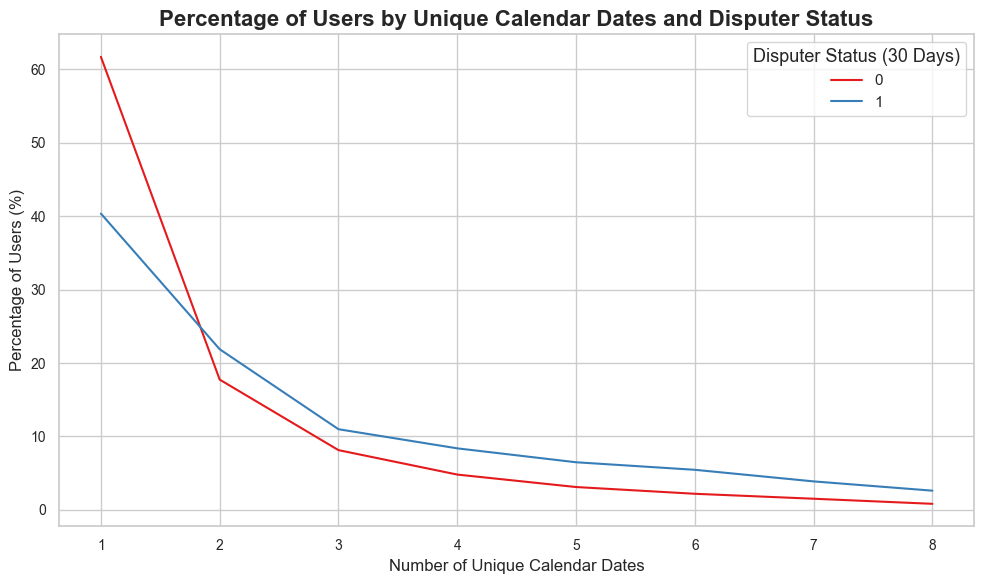

In [10]:
# Step 1: Group by 'new_disputer_30d' and 'unique_dates_count', then count the number of occurrences (users)
df_grouped = df.groupby(['new_disputer_30d', 'unique_dates_count']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='unique_dates_count', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Unique Calendar Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Number of Unique Calendar Dates', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()


# Day 28

In [5]:
final_query = f"""
select * 
from temp.day_28_distinct_day_analysis_table a
"""

print(final_query)


select * 
from temp.day_28_distinct_day_analysis_table a



In [6]:
df = pull_data(final_query, bs_token, host)
df['new_disputer_30d'] = df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)
df['new_disputer_30d'].mean()

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


0.004038075353240972

In [8]:
df_jul = df[df['first_pay_time'] > '2024-07-01']

In [9]:
# Apply the conversion
df['payment_history_time_clean'] = df['payment_history_time'].apply(convert_to_datetime_list)
df_jul['payment_history_time_clean'] = df_jul['payment_history_time'].apply(convert_to_datetime_list)

In [ ]:
# Apply the function to the 'euca' column
df[['items_count', 'unique_dates_count']] = df['payment_history_time_clean'].apply(count_items_and_unique_dates)
df_jul[['items_count', 'unique_dates_count']] = df_jul['payment_history_time_clean'].apply(count_items_and_unique_dates)

### Unique calendar days 

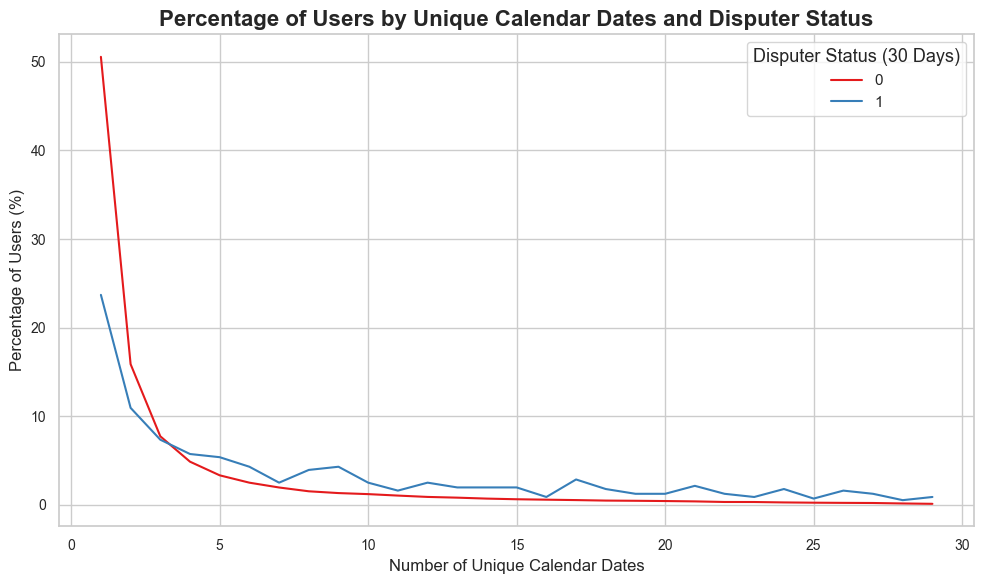

In [10]:
# Step 1: Group by 'new_disputer_30d' and 'unique_dates_count', then count the number of occurrences (users)
df_grouped = df.groupby(['new_disputer_30d', 'unique_dates_count']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='unique_dates_count', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Unique Calendar Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Number of Unique Calendar Dates', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()

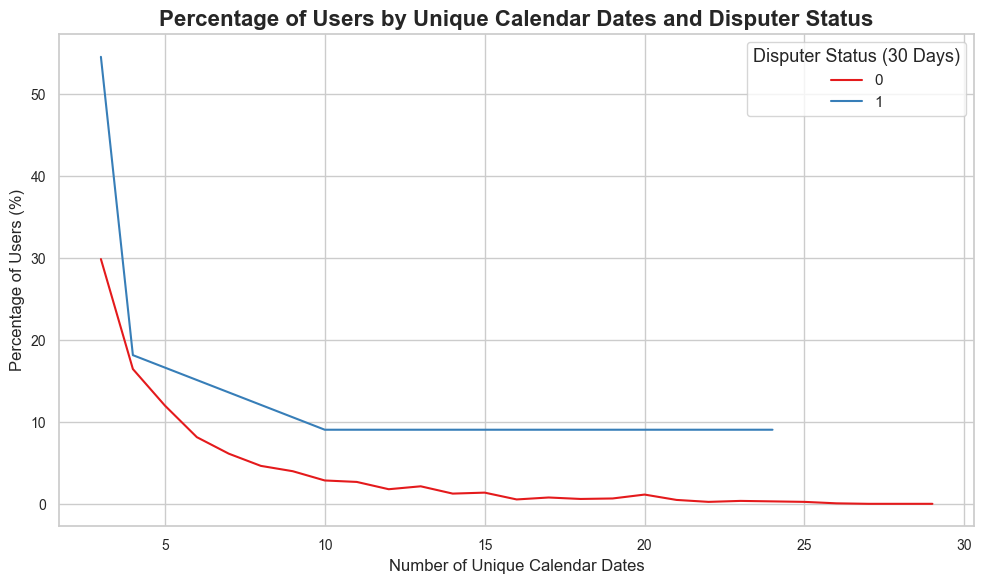

In [11]:
# Step 1: Group by 'new_disputer_30d' and 'unique_dates_count', then count the number of occurrences (users) - You also need to 
df_grouped = df_jul[df_jul['unique_dates_count'] > 2].groupby(['new_disputer_30d', 'unique_dates_count']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='unique_dates_count', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Unique Calendar Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Number of Unique Calendar Dates', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()


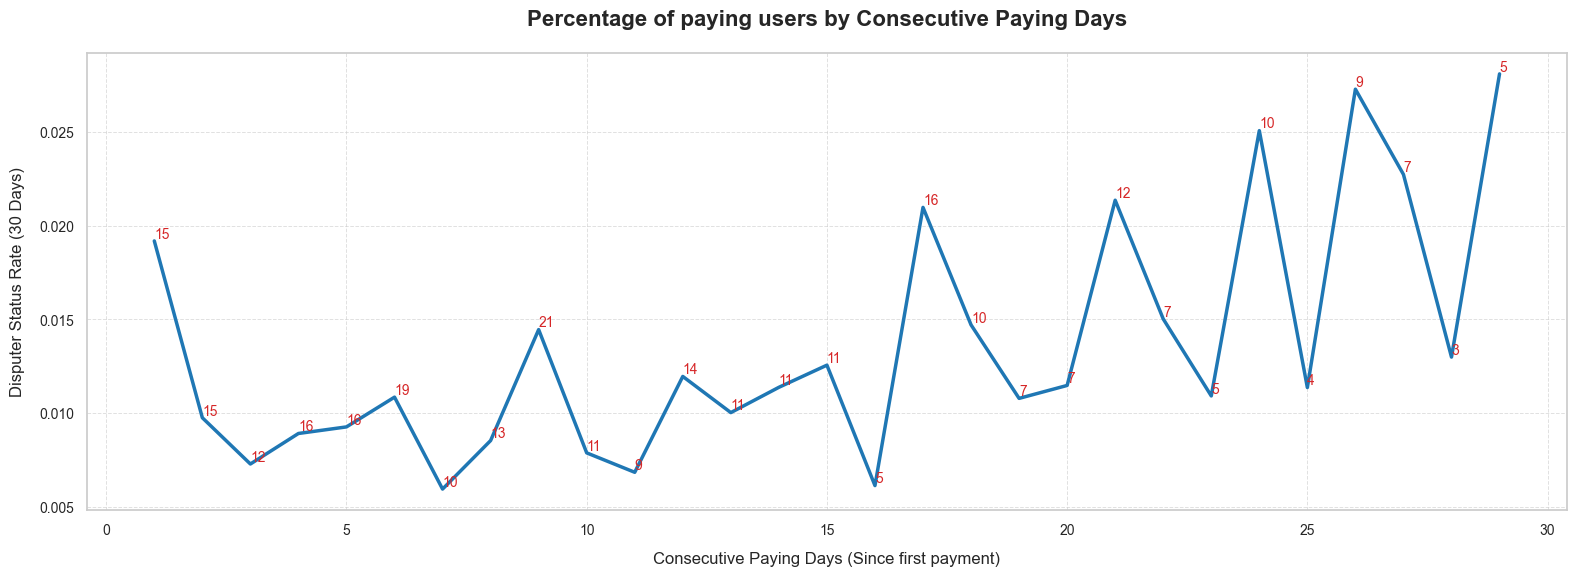

In [19]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['unique_dates_count'] >= 1][df['payment_d28'] >= 100]

# Step 2: Calculate the average and sum of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_avg_sum = df_filtered.groupby('unique_dates_count', as_index=False).agg(
    average_disputers=('new_disputer_30d', 'mean'),
    sum_disputers=('new_disputer_30d', 'sum'), 
    user_count=('new_disputer_30d', 'size')  # Count the number of users in each group

)

# Step 3: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 4: Create the line plot with average 'new_disputer_30d'
sns.lineplot(data=df_avg_sum, x='unique_dates_count', y='average_disputers', color='#1f77b4', linewidth=2.5)

# Step 5: Customize the plot for a McKinsey-style look
plt.title('Percentage of paying users by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days (Since first payment)', fontsize=12, labelpad=10)
plt.ylabel('Disputer Status Rate (30 Days)', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add the sum of disputes as a secondary annotation on the plot
for i in range(len(df_avg_sum)):
    plt.text(df_avg_sum['unique_dates_count'].iloc[i],
             df_avg_sum['average_disputers'].iloc[i], 
             f"{df_avg_sum['sum_disputers'].iloc[i]:.0f}",
             color='#d62728', ha='left', va='bottom', fontsize=10)

# Step 7: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 8: Display the plot
plt.show()


### Consecutive days ying since first payment

In [29]:
def consecutive_days_since_first_payment(dates_list):
    # Convert the list of datetime strings to pandas datetime objects
    dates = pd.to_datetime(dates_list).normalize()  # Normalize to remove time info
    # Sort dates in ascending order
    dates = sorted(dates)
    if len(dates) < 1:
        return 0
    # Calculate the difference in days between each date and the first payment date
    first_date = dates[0]
    last_date = dates[-1]
    # Calculate the difference in days between the first and last payment
    return (last_date - first_date).days + 1  # Include the first day as well

# Function to calculate the maximum number of continuous days paying
def max_continuous_days(dates_list):
    # Convert the list of datetime strings to pandas datetime objects
    dates = pd.to_datetime(dates_list).normalize()  # Normalize to remove time info
    # Remove duplicate dates and sort dates in ascending order
    dates = sorted(set(dates))  # Use set to remove duplicates
    if len(dates) < 2:
        return len(dates)  # If only one date, return 1
    # Calculate the difference between consecutive dates and check for consecutive streaks
    max_streak = 1
    current_streak = 1
    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days == 1:
            current_streak += 1
        else:
            max_streak = max(max_streak, current_streak)
            current_streak = 1
    # Ensure to compare the last streak
    max_streak = max(max_streak, current_streak)
    return max_streak

# Apply these functions to the 'euca' column in your DataFrame
df['consecutive_days_since_first_payment'] = df['payment_history_time_clean'].apply(consecutive_days_since_first_payment)
df['max_continuous_days'] = df['payment_history_time_clean'].apply(max_continuous_days)

# Now, you will have two new columns:
# - 'consecutive_days_since_first_payment': the number of days from the first payment to the last recorded day
# - 'max_continuous_days': the maximum number of continuous days with payments

In [30]:
def consecutive_days_paid_from_first(dates_list):
    # Convert the list of datetime strings to pandas datetime objects
    dates = pd.to_datetime(dates_list).normalize()  # Normalize to remove time info (get only the date part)
    
    # Get unique calendar dates (ignore multiple payments on the same day)
    unique_dates = sorted(dates.unique())
    
    if len(unique_dates) < 2:
        return len(unique_dates)  # If there's 1 or fewer unique dates, return that count
    
    consecutive_streak = 1  # Initialize streak starting from the first day
    for i in range(1, len(unique_dates)):
        # Check if the current date is exactly 1 day after the previous one
        if (unique_dates[i] - unique_dates[i - 1]).days == 1:
            consecutive_streak += 1
        else:
            break  # Stop the streak if there is a gap between dates
    
    return consecutive_streak

# Apply the function to calculate consecutive days paid from the first payment
df['consecutive_days_paid_from_first'] = df['payment_history_time_clean'].apply(consecutive_days_paid_from_first)

In [14]:
df[['payment_history_time_clean', 'consecutive_days_paid_from_first', 'max_continuous_days', 'unique_dates_count']].sample(1).values[0]

array([DatetimeIndex(['2024-03-10 17:30:41.857000', '2024-03-11 17:08:55.872000',
                      '2024-03-13 08:26:12.922000', '2024-03-13 08:32:57.354000'],
                     dtype='datetime64[ns]', freq=None)                           ,
       2, 2, 3], dtype=object)

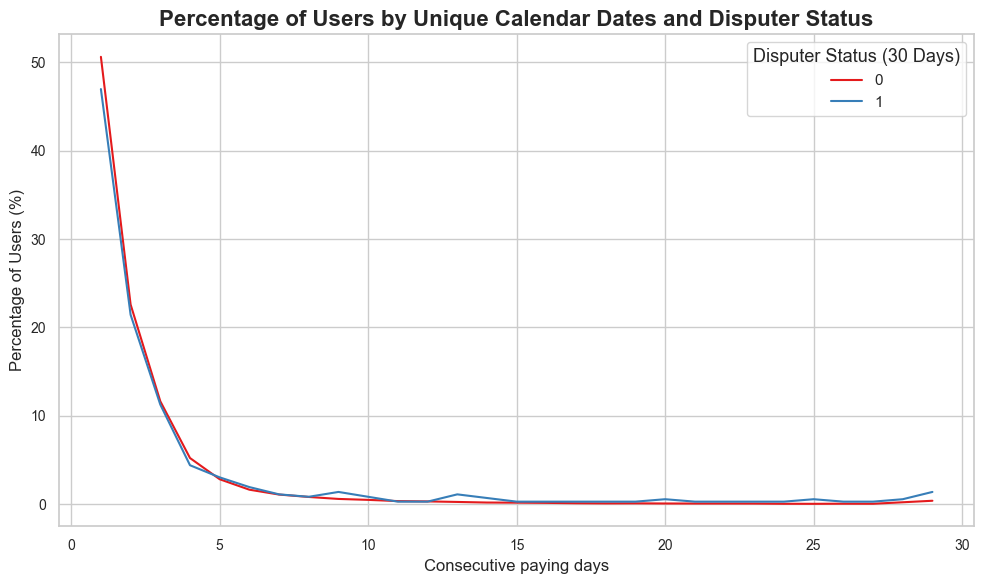

In [15]:
df_grouped = df[df['unique_dates_count'] > 2].groupby(['new_disputer_30d', 'consecutive_days_paid_from_first']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='consecutive_days_paid_from_first', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Unique Calendar Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Consecutive paying days', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()


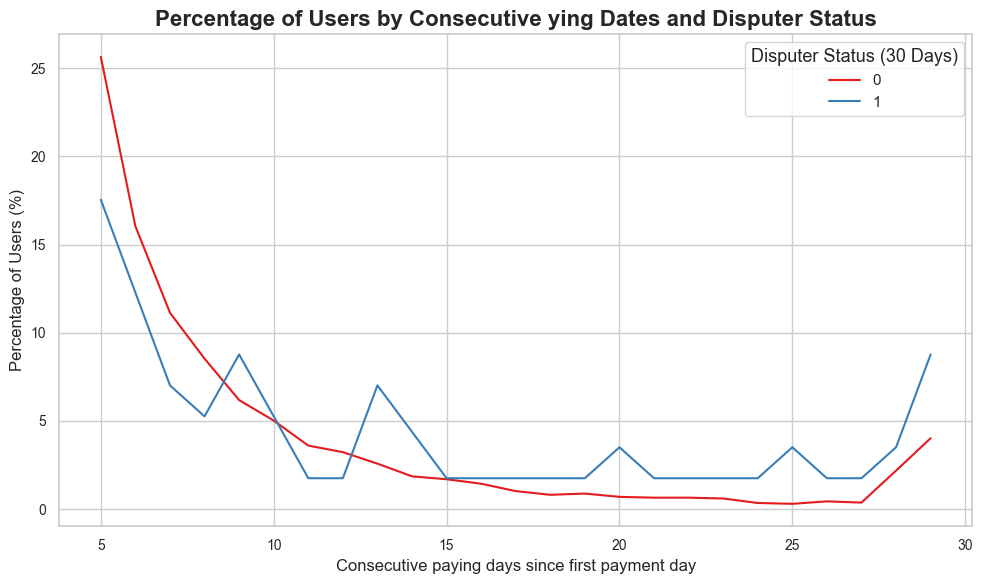

In [20]:
df_grouped = df[df['consecutive_days_paid_from_first'] >= 5][df['payment_d28'] >= 100].groupby(['new_disputer_30d', 'consecutive_days_paid_from_first']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='consecutive_days_paid_from_first', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Consecutive ying Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Consecutive paying days since first payment day', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()


### IDK what this is now

In [ ]:
# I am going to break uffff this fucking shit because it is huge shit 



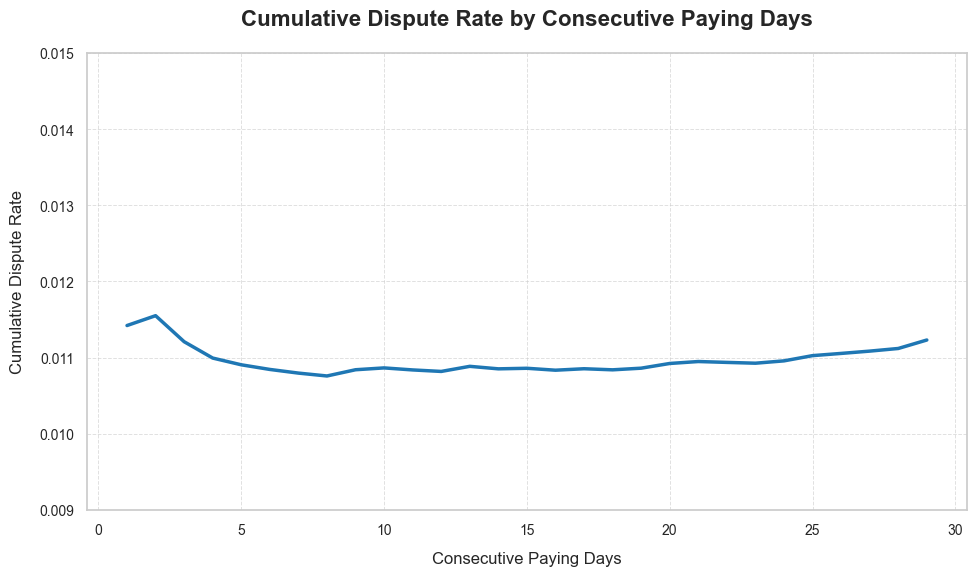

In [18]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['consecutive_days_paid_from_first'] >= 1][df['payment_d28'] >= 100]
# df_filtered = df[df['consecutive_days_paid_from_first'] >= 1]

# Step 2: Sort the data by 'consecutive_days_paid_from_first'
df_filtered = df_filtered.sort_values(by='consecutive_days_paid_from_first')

# Step 3: Calculate the cumulative average of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_filtered['cumulative_dispute_rate'] = df_filtered['new_disputer_30d'].expanding().mean()

# Step 4: Group by 'consecutive_days_paid_from_first' to plot unique consecutive days with cumulative rates
df_cumulative = df_filtered.groupby('consecutive_days_paid_from_first', as_index=False)['cumulative_dispute_rate'].last()

# Set parameters for the Y-axis limits (you can adjust these values as needed)
y_min = 0.009  # Minimum value for the Y-axis
y_max = 0.015  # Maximum value for the Y-axis

# Step 5: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 6: Create the line plot with the cumulative dispute rate
sns.lineplot(data=df_cumulative, x='consecutive_days_paid_from_first', y='cumulative_dispute_rate', color='#1f77b4', linewidth=2.5)

# Step 7: Customize the plot for a McKinsey-style look
plt.title('Cumulative Dispute Rate by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days', fontsize=12, labelpad=10)
plt.ylabel('Cumulative Dispute Rate', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 8: Set the Y-axis limits using the y_min and y_max parameters
plt.ylim(y_min, y_max)

# Step 9: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 10: Display the plot
plt.show()


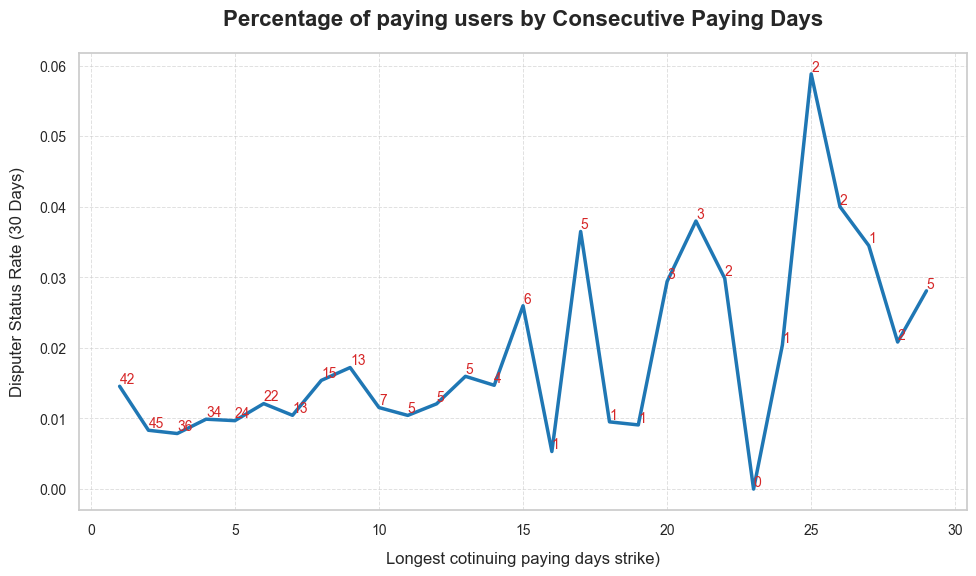

In [19]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['consecutive_days_paid_from_first'] >= 1][df['payment_d28'] >= 100]

# Step 2: Calculate the average and sum of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_avg_sum = df_filtered.groupby('max_continuous_days', as_index=False).agg(
    average_disputers=('new_disputer_30d', 'mean'),
    sum_disputers=('new_disputer_30d', 'sum'), 
    user_count=('new_disputer_30d', 'size')  # Count the number of users in each group

)

# Step 3: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 4: Create the line plot with average 'new_disputer_30d'
sns.lineplot(data=df_avg_sum, x='max_continuous_days', y='average_disputers', color='#1f77b4', linewidth=2.5)

# Step 5: Customize the plot for a McKinsey-style look
plt.title('Percentage of paying users by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Longest cotinuing paying days strike)', fontsize=12, labelpad=10)
plt.ylabel('Disputer Status Rate (30 Days)', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add the sum of disputes as a secondary annotation on the plot
for i in range(len(df_avg_sum)):
    plt.text(df_avg_sum['max_continuous_days'].iloc[i],
             df_avg_sum['average_disputers'].iloc[i], 
             f"{df_avg_sum['sum_disputers'].iloc[i]:.0f}",
             color='#d62728', ha='left', va='bottom', fontsize=10)

# Step 7: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 8: Display the plot
plt.show()


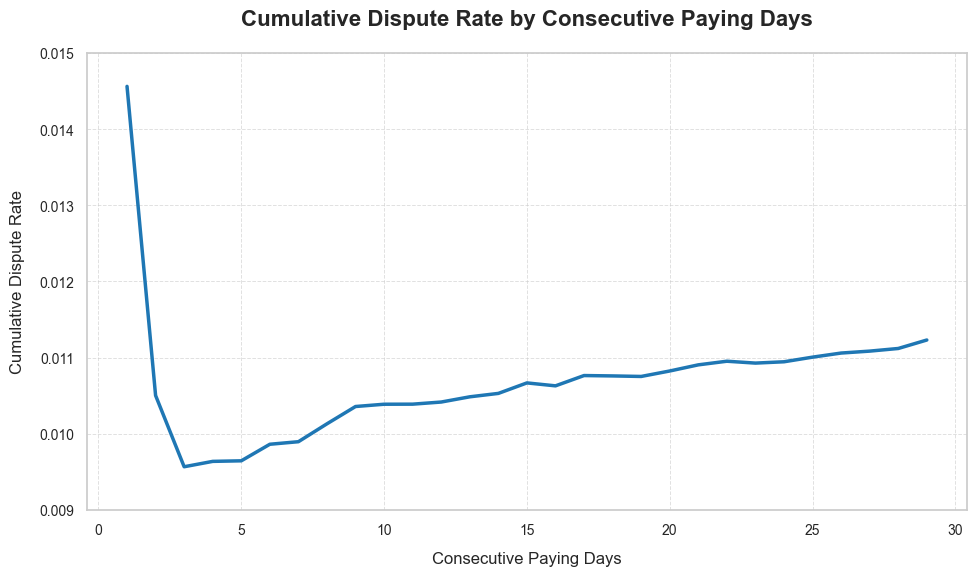

In [20]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['consecutive_days_paid_from_first'] >= 1][df['payment_d28'] >= 100]
# df_filtered = df[df['consecutive_days_paid_from_first'] >= 1]

# Step 2: Sort the data by 'consecutive_days_paid_from_first'
df_filtered = df_filtered.sort_values(by='max_continuous_days')

# Step 3: Calculate the cumulative average of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_filtered['cumulative_dispute_rate'] = df_filtered['new_disputer_30d'].expanding().mean()

# Step 4: Group by 'consecutive_days_paid_from_first' to plot unique consecutive days with cumulative rates
df_cumulative = df_filtered.groupby('max_continuous_days', as_index=False)['cumulative_dispute_rate'].last()

# Set parameters for the Y-axis limits (you can adjust these values as needed)
y_min = 0.009  # Minimum value for the Y-axis
y_max = 0.015  # Maximum value for the Y-axis

# Step 5: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 6: Create the line plot with the cumulative dispute rate
sns.lineplot(data=df_cumulative, x='max_continuous_days', y='cumulative_dispute_rate', color='#1f77b4', linewidth=2.5)

# Step 7: Customize the plot for a McKinsey-style look
plt.title('Cumulative Dispute Rate by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days', fontsize=12, labelpad=10)
plt.ylabel('Cumulative Dispute Rate', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 8: Set the Y-axis limits using the y_min and y_max parameters
plt.ylim(y_min, y_max)

# Step 9: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 10: Display the plot
plt.show()


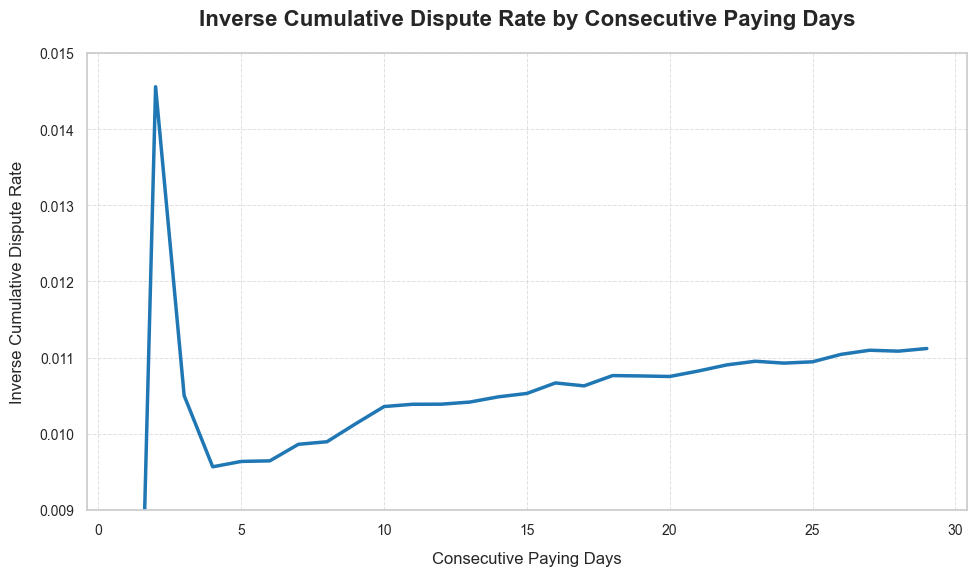

In [21]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['consecutive_days_paid_from_first'] >= 1][df['payment_d28'] >= 100]

# Step 2: Sort the data by 'max_continuous_days' in descending order (to calculate inverse cumulative)
df_filtered = df_filtered.sort_values(by='max_continuous_days', ascending=False)

# Step 3: Calculate the inverse cumulative of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_filtered['inverse_cumulative_dispute_rate'] = df_filtered['new_disputer_30d'].iloc[::-1].expanding().mean()

# Step 4: Group by 'max_continuous_days' to plot unique consecutive days with inverse cumulative rates
df_inverse_cumulative = df_filtered.groupby('max_continuous_days', as_index=False)['inverse_cumulative_dispute_rate'].last()

# Set parameters for the Y-axis limits (you can adjust these values as needed)
y_min = 0.009  # Minimum value for the Y-axis
y_max = 0.015  # Maximum value for the Y-axis

# Step 5: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 6: Create the line plot with the inverse cumulative dispute rate
sns.lineplot(data=df_inverse_cumulative, x='max_continuous_days', y='inverse_cumulative_dispute_rate', color='#1f77b4', linewidth=2.5)

# Step 7: Customize the plot for a McKinsey-style look
plt.title('Inverse Cumulative Dispute Rate by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days', fontsize=12, labelpad=10)
plt.ylabel('Inverse Cumulative Dispute Rate', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 8: Set the Y-axis limits using the y_min and y_max parameters
plt.ylim(y_min, y_max)

# Step 9: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 10: Display the plot
plt.show()


In [22]:
df[['payment_history_time_clean', 'consecutive_days_paid_from_first', 'max_continuous_days', 'unique_dates_count']].sample(1).values[0]

df[df['consecutive_days_paid_from_first'] > df['max_continuous_days'] + 1][['payment_history_time_clean', 'consecutive_days_paid_from_first', 'max_continuous_days', 'unique_dates_count']].sample(1).values[0]

ValueError: a must be greater than 0 unless no samples are taken

### Acorn Slots - Max Consecutive paying days since the first payment 

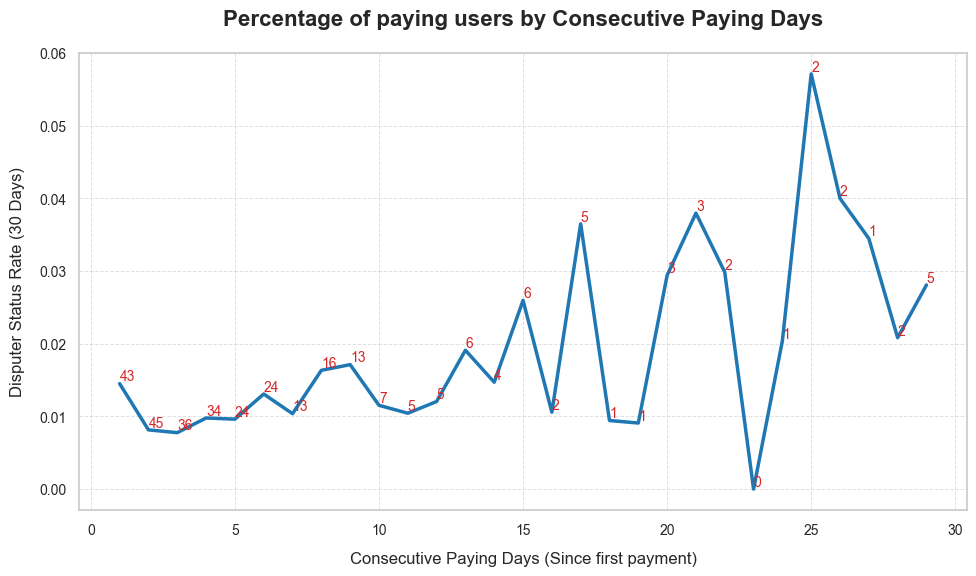

In [32]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['consecutive_days_paid_from_first'] >= 1][df['payment_d28'] >= 100]

# Step 2: Calculate the average and sum of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_avg_sum = df_filtered.groupby('max_continuous_days', as_index=False).agg(
    average_disputers=('new_disputer_30d', 'mean'),
    sum_disputers=('new_disputer_30d', 'sum'), 
    user_count=('new_disputer_30d', 'size')  # Count the number of users in each group

)

# Step 3: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 4: Create the line plot with average 'new_disputer_30d'
sns.lineplot(data=df_avg_sum, x='max_continuous_days', y='average_disputers', color='#1f77b4', linewidth=2.5)

# Step 5: Customize the plot for a McKinsey-style look
plt.title('Percentage of paying users by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days (Since first payment)', fontsize=12, labelpad=10)
plt.ylabel('Disputer Status Rate (30 Days)', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add the sum of disputes as a secondary annotation on the plot
for i in range(len(df_avg_sum)):
    plt.text(df_avg_sum['max_continuous_days'].iloc[i],
             df_avg_sum['average_disputers'].iloc[i], 
             f"{df_avg_sum['sum_disputers'].iloc[i]:.0f}",
             color='#d62728', ha='left', va='bottom', fontsize=10)

# Step 7: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 8: Display the plot
plt.show()


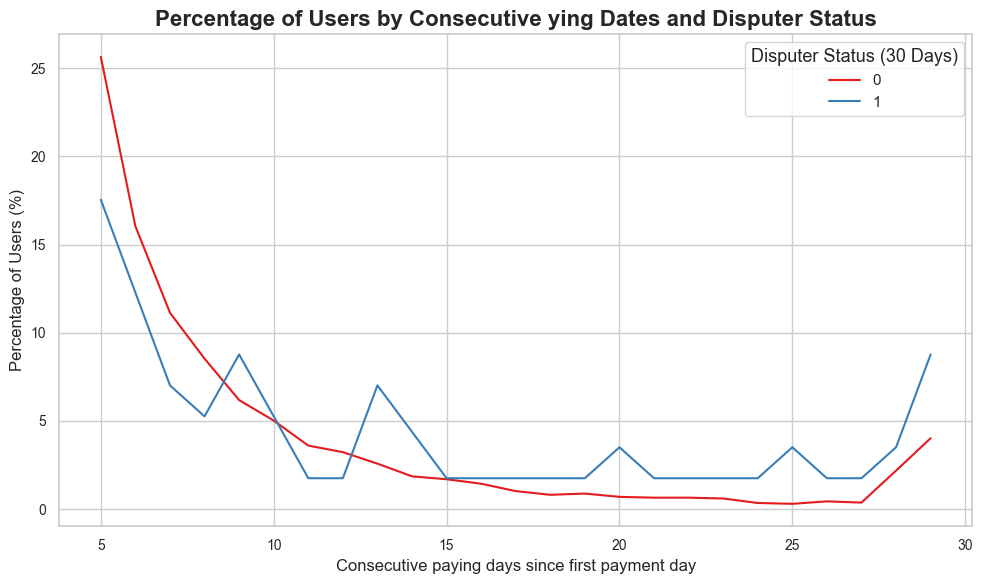

In [33]:
df_grouped = df[df['consecutive_days_paid_from_first'] >= 5][df['payment_d28'] >= 100].groupby(['new_disputer_30d', 'consecutive_days_paid_from_first']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='consecutive_days_paid_from_first', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Consecutive ying Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Consecutive paying days since first payment day', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()


### Acorn Slots - Consecutive paying days since the first payment 

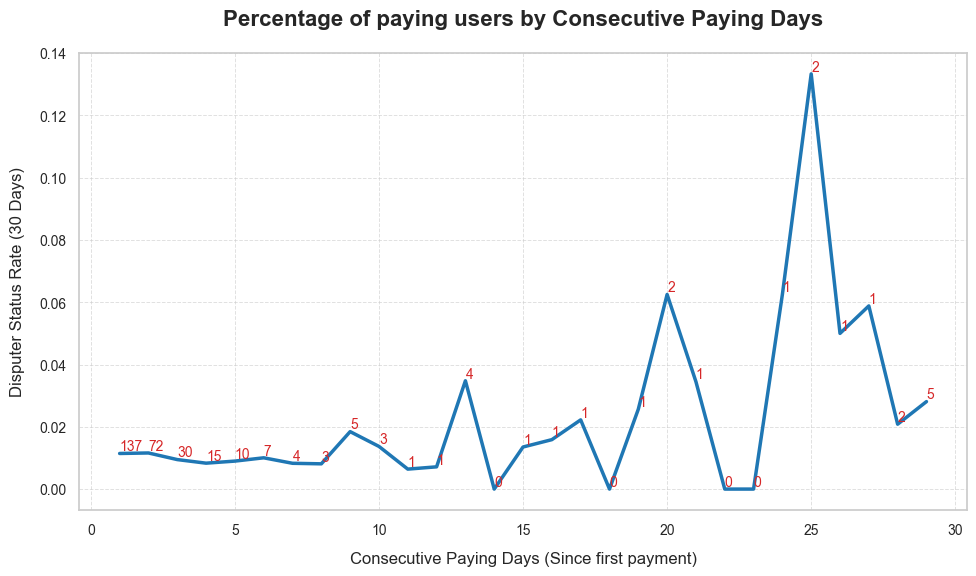

In [31]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['consecutive_days_paid_from_first'] >= 1][df['payment_d28'] >= 100]

# Step 2: Calculate the average and sum of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_avg_sum = df_filtered.groupby('consecutive_days_paid_from_first', as_index=False).agg(
    average_disputers=('new_disputer_30d', 'mean'),
    sum_disputers=('new_disputer_30d', 'sum'), 
    user_count=('new_disputer_30d', 'size')  # Count the number of users in each group

)

# Step 3: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 4: Create the line plot with average 'new_disputer_30d'
sns.lineplot(data=df_avg_sum, x='consecutive_days_paid_from_first', y='average_disputers', color='#1f77b4', linewidth=2.5)

# Step 5: Customize the plot for a McKinsey-style look
plt.title('Percentage of paying users by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days (Since first payment)', fontsize=12, labelpad=10)
plt.ylabel('Disputer Status Rate (30 Days)', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add the sum of disputes as a secondary annotation on the plot
for i in range(len(df_avg_sum)):
    plt.text(df_avg_sum['consecutive_days_paid_from_first'].iloc[i],
             df_avg_sum['average_disputers'].iloc[i], 
             f"{df_avg_sum['sum_disputers'].iloc[i]:.0f}",
             color='#d62728', ha='left', va='bottom', fontsize=10)

# Step 7: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 8: Display the plot
plt.show()


In [ ]:
df_grouped = df[df['consecutive_days_paid_from_first'] >= 5][df['payment_d28'] >= 100].groupby(['new_disputer_30d', 'consecutive_days_paid_from_first']).size().reset_index(name='user_count')

# Step 2: Calculate the percentage of users per 'new_disputer_30d' group
df_grouped['percentage_users'] = df_grouped.groupby('new_disputer_30d')['user_count'].transform(lambda x: (x / x.sum()) * 100)

# Step 3: Set up the plotting style for a clean professional look
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Use a clean grid style

# Step 4: Create the line plot, with each group as a separate line
sns.lineplot(data=df_grouped, x='consecutive_days_paid_from_first', y='percentage_users', hue='new_disputer_30d', palette='Set1')

# Step 5: Customize the plot for a CEO-level presentation
plt.title('Percentage of Users by Consecutive ying Dates and Disputer Status', fontsize=16, weight='bold')
plt.xlabel('Consecutive paying days since first payment day', fontsize=12)
plt.ylabel('Percentage of Users (%)', fontsize=12)
plt.legend(title='Disputer Status (30 Days)', title_fontsize='13', fontsize='11', loc='best')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add finishing touches for professionalism
plt.grid(True)
plt.tight_layout()  # Ensures the plot fits neatly within the figure area

# Step 7: Display the plot
plt.show()


In [25]:
df.columns

Index(['#account_id', 'already_disputed', 'bundle_id', 'disputable_payment',
       'disputed_amount_d30', 'disputes_d30', 'first_pay_time',
       'hours_first_payment', 'payment_d28', 'payment_enter_history',
       'payment_history', 'payment_history_time', 'payment_methods_score',
       'payment_methods_sequence', 'withdraw_history', 'withdraw_history_time',
       'new_disputer_30d', 'payment_history_time_clean', 'days_to_28th'],
      dtype='object')

### Distance to last one

In [15]:
import pandas as pd
from datetime import timedelta


def get_days_to_28th(df_row):
    # Extract payment dates from the list and ensure they are in datetime format
    payment_dates = pd.to_datetime(df_row['payment_history_time_clean'])
    
    # Get the first and last payment dates
    first_payment_date = min(payment_dates)
    last_payment_date = max(payment_dates)
    
    # Calculate the 28th day since the first payment
    twenty_eighth_day = first_payment_date + timedelta(days=28)
    
    # Calculate the difference between the last payment date and the 28th day
    days_to_28th = (twenty_eighth_day - last_payment_date).days
    
    return days_to_28th

# Apply the function to each row of the dataframe
df['days_to_28th'] = df.apply(get_days_to_28th, axis=1)


In [16]:
df['days_to_28th']

0         22
1          1
2         27
3          8
4         25
          ..
137932    27
137933    22
137934    27
137935    28
137936    27
Name: days_to_28th, Length: 137937, dtype: int64

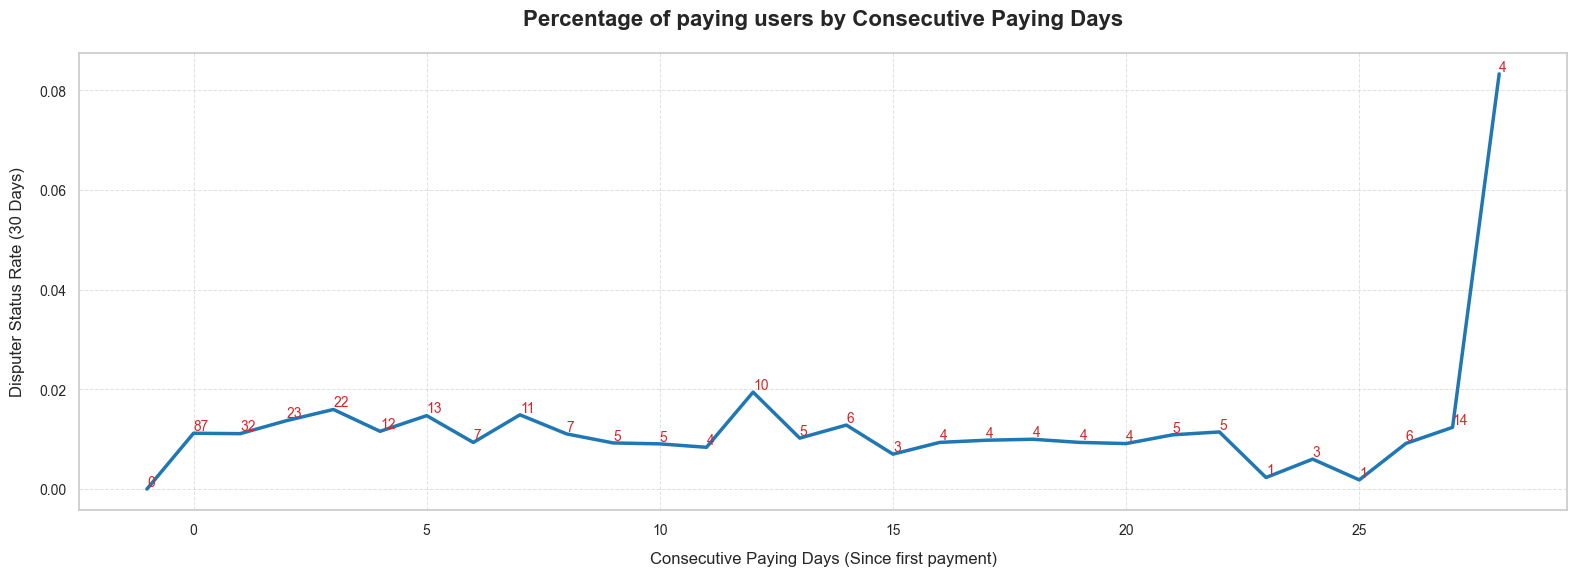

In [18]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['payment_d28'] >= 100]

# Step 2: Calculate the average and sum of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_avg_sum = df_filtered.groupby('days_to_28th', as_index=False).agg(
    average_disputers=('new_disputer_30d', 'mean'),
    sum_disputers=('new_disputer_30d', 'sum'), 
    user_count=('new_disputer_30d', 'size')  # Count the number of users in each group

)

# Step 3: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 4: Create the line plot with average 'new_disputer_30d'
sns.lineplot(data=df_avg_sum, x='days_to_28th', y='average_disputers', color='#1f77b4', linewidth=2.5)

# Step 5: Customize the plot for a McKinsey-style look
plt.title('Percentage of paying users by Consecutive Paying Days', fontsize=16, weight='bold', pad=20)
plt.xlabel('Consecutive Paying Days (Since first payment)', fontsize=12, labelpad=10)
plt.ylabel('Disputer Status Rate (30 Days)', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add the sum of disputes as a secondary annotation on the plot
for i in range(len(df_avg_sum)):
    plt.text(df_avg_sum['days_to_28th'].iloc[i],
             df_avg_sum['average_disputers'].iloc[i], 
             f"{df_avg_sum['sum_disputers'].iloc[i]:.0f}",
             color='#d62728', ha='left', va='bottom', fontsize=10)

# Step 7: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 8: Display the plot
plt.show()


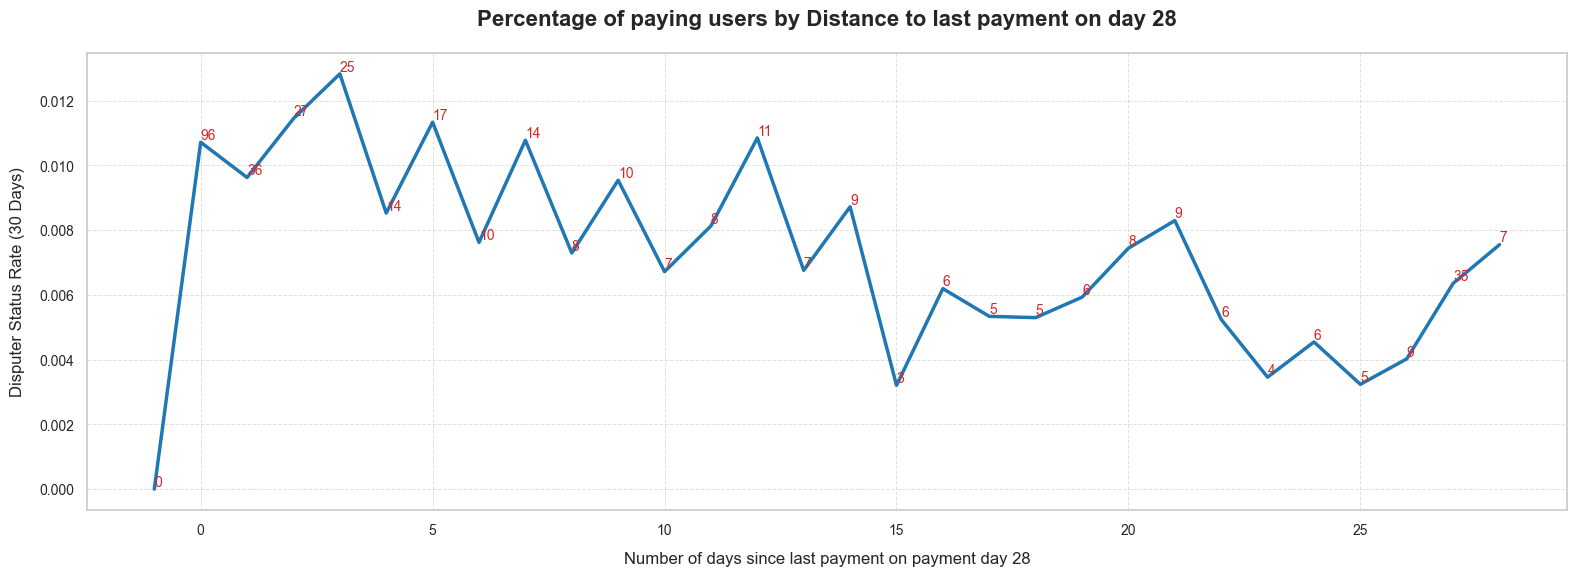

In [24]:
# Step 1: Filter the data based on conditions
df_filtered = df[df['payment_d28'] >= 30]

# Step 2: Calculate the average and sum of 'new_disputer_30d' for each 'consecutive_days_paid_from_first'
df_avg_sum = df_filtered.groupby('days_to_28th', as_index=False).agg(
    average_disputers=('new_disputer_30d', 'mean'),
    sum_disputers=('new_disputer_30d', 'sum'), 
    user_count=('new_disputer_30d', 'size')  # Count the number of users in each group

)

# Step 3: Set up McKinsey-style plotting aesthetics
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid", font_scale=1.2)  # Clean grid and slightly larger font for readability

# Step 4: Create the line plot with average 'new_disputer_30d'
sns.lineplot(data=df_avg_sum, x='days_to_28th', y='average_disputers', color='#1f77b4', linewidth=2.5)

# Step 5: Customize the plot for a McKinsey-style look
plt.title('Percentage of paying users by Distance to last payment on day 28', fontsize=16, weight='bold', pad=20)
plt.xlabel('Number of days since last payment on payment day 28', fontsize=12, labelpad=10)
plt.ylabel('Disputer Status Rate (30 Days)', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Step 6: Add the sum of disputes as a secondary annotation on the plot
for i in range(len(df_avg_sum)):
    plt.text(df_avg_sum['days_to_28th'].iloc[i],
             df_avg_sum['average_disputers'].iloc[i], 
             f"{df_avg_sum['sum_disputers'].iloc[i]:.0f}",
             color='#d62728', ha='left', va='bottom', fontsize=10)

# Step 7: Final McKinsey-style touchups
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)  # Light grid lines for a clean look
plt.tight_layout()

# Step 8: Display the plot
plt.show()
